In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
# Set seed for reproducibility
np.random.seed(42)

# Number of samples
n_samples = 100

# Generate random values for x1 and x2
x1 = np.random.uniform(10, 10000, n_samples)
x2 = np.random.uniform(10, 10000, n_samples)

# Generate random error terms
error = np.random.uniform(0, 2, n_samples)

# Compute y_low and y_high
y_low = 2*x1**0.2 + 3*x2**0.3 + 2 - error**2
y_high = 2*x1**0.2 + 3*x2**0.3 + 2 + error**2

# Create a DataFrame to hold the data
data = pd.DataFrame({
    'x1': x1,
    'x2': x2,
    'y_low': y_low,
    'y_high': y_high
})

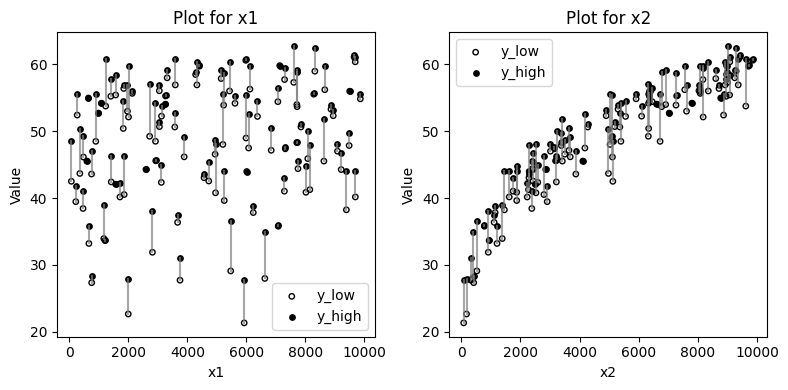

In [3]:
# Create a figure and a grid of subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Plot for x1
for xi1, yi_low, yi_high in zip(x1, y_low, y_high):
    ax1.plot([xi1, xi1], [yi_low, yi_high], color='gray', alpha=0.7)
ax1.scatter(x1, y_low, edgecolor='black', facecolor='none', label='y_low', s=15)
ax1.scatter(x1, y_high, color='black', label='y_high', s=15)
ax1.set_title('Plot for x1')
ax1.set_xlabel('x1')
ax1.set_ylabel('Value')
ax1.legend()

# Plot for x2
for xi2, yi_low, yi_high in zip(x2, y_low, y_high):
    ax2.plot([xi2, xi2], [yi_low, yi_high], color='gray', alpha=0.7)
ax2.scatter(x2, y_low, edgecolor='black', facecolor='none', label='y_low', s=15)
ax2.scatter(x2, y_high, color='black', label='y_high', s=15)
ax2.set_title('Plot for x2')
ax2.set_xlabel('x2')
ax2.set_ylabel('Value')
ax2.legend()

# Adjust layout
plt.tight_layout()
plt.show()

In [4]:
class SquaredHingeLoss(nn.Module):
    def __init__(self, margin=0):
        super(SquaredHingeLoss, self).__init__()
        self.margin = margin

    def forward(self, predicted, y):
        low, high = y[:, 0:1], y[:, 1:2]
        loss_low = torch.relu(low - predicted + self.margin)
        loss_high = torch.relu(predicted - high + self.margin)
        loss = loss_low + loss_high
        return torch.mean(torch.square(loss))

In [5]:
class ExponentialNN(nn.Module):
    def __init__(self, input_dim):
        super(ExponentialNN, self).__init__()
        self.input_dim = input_dim
        self.W = nn.Parameter(torch.randn(input_dim))
        self.output = nn.Linear(input_dim, 1)

    def forward(self, x):
        hidden = torch.pow(x, self.W)
        output = self.output(hidden)
        return output

In [6]:
x1 = torch.tensor(x1, dtype=torch.float32)
x2 = torch.tensor(x2, dtype=torch.float32)
y_low = torch.tensor(y_low, dtype=torch.float32)
y_high = torch.tensor(y_high, dtype=torch.float32)

In [7]:
X_tensor = torch.stack([x1, x2], dim=1)
y_tensor = torch.stack([y_low, y_high], dim=1)

In [8]:
# Initialize model, loss function, and optimizer
input_dim = 2
model = ExponentialNN(input_dim)
criterion = SquaredHingeLoss(margin=0.5)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
# Training loop
num_epochs = 500000             # Number of epochs
patience = 5000                 # Number of epochs with no improvement to wait before stopping
best_loss = float('inf')        # Initialize best loss with a large value
epochs_without_improvement = 0  # Counter for epochs without improvement

for epoch in range(num_epochs):
    model.train()
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print loss every 10000 epochs
    if epoch % 10000 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item()}')
    
    # Check if loss has decreased
    if loss.item() < best_loss:
        best_loss = loss.item()
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    # Stop training if loss does not improve for `patience` epochs
    if epochs_without_improvement >= patience:
        print(f'Stopping early at epoch {epoch} due to no improvement in loss.')
        break

Epoch [0/500000], Loss: 93865243574272.0
Epoch [10000/500000], Loss: 101749440.0
Epoch [20000/500000], Loss: 83383.2578125
Epoch [30000/500000], Loss: 1633.3251953125
Epoch [40000/500000], Loss: 3.0704190731048584
Epoch [50000/500000], Loss: 1.4636601209640503
Epoch [60000/500000], Loss: 0.5658725500106812
Epoch [70000/500000], Loss: 0.33268260955810547
Epoch [80000/500000], Loss: 0.22100688517093658
Epoch [90000/500000], Loss: 0.20226651430130005
Epoch [100000/500000], Loss: 0.19531428813934326
Epoch [110000/500000], Loss: 0.19071565568447113
Epoch [120000/500000], Loss: 0.18866543471813202
Epoch [130000/500000], Loss: 0.18733935058116913
Epoch [140000/500000], Loss: 0.18657805025577545
Epoch [150000/500000], Loss: 0.18613548576831818
Epoch [160000/500000], Loss: 0.18590152263641357
Epoch [170000/500000], Loss: 0.18602114915847778
Epoch [180000/500000], Loss: 0.18555320799350739
Epoch [190000/500000], Loss: 0.18560169637203217
Epoch [200000/500000], Loss: 0.18540403246879578
Epoch [21

In [10]:
for name, param in model.named_parameters():
    print(f"{name}: {param.data}")

W: tensor([0.2651, 0.3099])
output.weight: tensor([[0.9123, 2.6869]])
output.bias: tensor([5.2107])
